In [44]:
# optimizer with scaling and mlp regressor

import pandas as pd
import warnings
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.compose import make_column_transformer
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')

df = df[:1350]

dfTerranReg = df[df["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]
X = dfTerranReg[["total_workers", "supply"]]
y = dfTerranReg["resource_mining"]


# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

feat_transform = make_column_transformer(
    (StandardScaler(), ["total_workers", "supply"]),
)

scaler = StandardScaler()
lin_reg = make_pipeline(feat_transform, MLPRegressor(random_state=1, max_iter=15000, learning_rate="adaptive"))
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
print(f"The R^2 value in the test set is {r2_score(y_test, y_pred)}")


data = pd.read_csv('csv_dateien/starcraftFinalcsvs/stackedRunSup.csv')
data = data[1350:]

dfTerran = data[data["fraction"] == "Terraner"]
dfTerranReg = dfTerranReg[dfTerranReg["supply"] > 0]


# ,player,total_workers,total_army_value,total_army,fraction,winner,replay_filename
dfTerran = dfTerran.drop(columns=[
                               "total_workers", "player", "replay_filename", "winner", "fraction", "Unnamed: 0", "total_army_value", "time", "total_army"])



# create variables
# create Model

m = gp.Model("Worker optimizer")
gppd.set_interactive()

w = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_workers", vtype=gp.GRB.INTEGER)
r_ges = gppd.add_vars(m, pandas_obj=dfTerran,
                      name="resource_mining")
a = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="total_army", vtype=gp.GRB.INTEGER)
s = gppd.add_vars(m, pandas_obj=dfTerran,
                  name="supply", vtype=gp.GRB.INTEGER)

m.update()
dfTerran = dfTerran.drop(columns=["resource_mining"])

feats = dfTerran
feats = pd.concat([w, feats], axis=1)


m.setObjective(a.sum(), gp.GRB.MAXIMIZE) # Zielfunktion
gppd.add_constrs(m, ((r_ges - 50*w)/100), gp.GRB.GREATER_EQUAL, a) # Gleichung 2
gppd.add_constrs(m, w + a, gp.GRB.GREATER_EQUAL, 0) # Gleichung 3
gppd.add_constrs(m, w + a, gp.GRB.LESS_EQUAL, 200) # Gleichung 4
m.update()

pred_constr = add_predictor_constr(m, lin_reg, feats, r_ges) # Einfügen des Regressiosmodells
pred_constr.print_stats()
m.optimize()
outputs = pred_constr.input_values
outputs


FileNotFoundError: [Errno 2] No such file or directory: 'csv_dateien/starcraftFinalcsvs/stackedRunSup.csv'

In [ ]:

solution = pd.DataFrame()

solution["total_workers"] = w.gppd.X
solution["supply"] = dfTerran["supply"]

solution


,total_workers,supply
1350,0.0,165.0
1354,0.0,204.0
1357,55.0,31.0
1358,57.0,23.0
1359,37.0,101.0
...,...,...
3554,37.0,101.0
3555,39.0,93.0
3556,51.0,46.0
3557,15.0,125.0


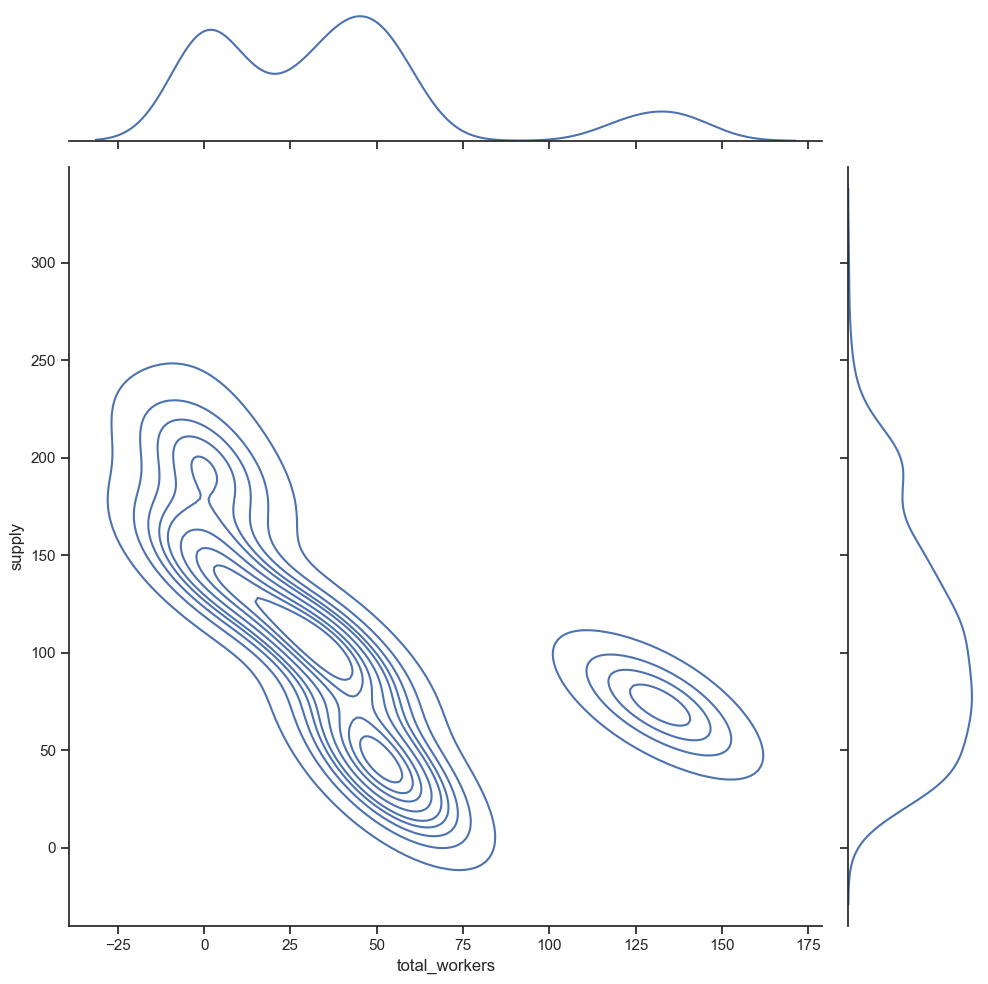

In [ ]:
custom_palette = ["#dd8452","#4c72b0",  "#55a868"]
sns.set_theme(style="ticks")
# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=solution, palette=custom_palette,
    x="total_workers", y="supply",  # ylim=[None, 150],
    kind="kde", height=10
)